## Importing necessary libaries and applying settings

In [1]:
from datetime import datetime # used for time format conversion
import os # access to host system to create directories and write files
import ftplib # libary to access ftp server
import urllib3 
import codecs
from zipfile import ZipFile # used for unzipping zip files
import numpy as np # numpy arrays and functions for example replacing bad values with true NotaNumber
import time
import matplotlib.pyplot as plt
%matplotlib inline 
# making plots available in jupyter output line
import pandas as pd # for pandas dataframe to read csv
#pd.options.display.max_seq_items = None # pandas printing options
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)
# pd.set_option('display.width', 1000)

## Defining variables

In [2]:
ftp_server = "opendata.dwd.de" # root of file server
ftp_user = "anonymous"
ftp_passwd = ""
ftp_dir =  "/climate_environment/CDC/observations_germany/climate/annual/kl/historical/" # directory
state = "Bayern" # Selected state to filter
years = [2017, 2018, 2019] # selected years
nyears = len(years) # length of years list
year_from = datetime.strptime(str(years[0])+"0101", '%Y%m%d') # lowest year from the list
year_to = datetime.strptime(str(years[nyears-1])+"1231", '%Y%m%d') # highest year from the list
stations_fname = "" # initializing variable

In [3]:
def connect_ftp(): # establishing connection to ftp server and check if it was successfull
    ftp = ftplib.FTP(ftp_server) # creating ftp server instance
    res = ftp.login(user = ftp_user, passwd = ftp_passwd) # logging in to server
    ret = ftp.cwd(ftp_dir) # Changing into correct ftp directory
    return ftp # return configured and connected ftp instance

In [4]:
def gen_df_ftp_dir():
    lines = [] # buffer for storing lines of ftp directory
    flist = [] # buffer for temporarily storing station_idm, zip file names and product file name
    try:
        res = ftp.retrlines("NLST", lines.append) # retrieve lines with NLST ftp command, which lsits file names including extention, the returned lines are appended to the lines buffer
    except:
        return
    global stations_fname # setting global variable to use filename later
    stations_fname = lines[0] # storing first line, which is the file name of the station description
    lines.pop(0) # removing station description file from buffer to read only zip files later
    for line in lines: # looping through elements of the lines buffer
        pname = "produkt_klima_jahr_"+line.split("_")[3]+"_"+line.split("_")[4]+"_"+line.split("_")[2]+".txt" # generating product file name
        flist.append([int(line.split("_")[2]), line, pname]) # reading variables into temporary list
    df_ftp_dir = pd.DataFrame(flist,columns=["station_id", "fname", "pname"]) # creating a pandas dataframe from flist, defining column names for elements in the list
    df_ftp_dir.set_index("station_id", inplace = True) # setting station_id column as index and replacing the standard numeration
    return df_ftp_dir # return the dataframe

In [5]:
def gen_df_station_desc_query():
    try:
        ftp.retrbinary('RETR '+ stations_fname, open(stations_fname, 'wb').write) # retrieve the binary code from the stations_fname file from ftp and writing to a newly opened file with the same filename
    except:
        return
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates] # function for parsing the dates from the txt, for each column in a row the value is converted to a string and parsed into a datetime object
    df_station_desc = pd.read_fwf(stations_fname, skiprows = 2, header=None, parse_dates = [1,2], date_parser = dateparse, encoding = 'latin-1') # encoding of txt is ISO-8859-1/latin (german umlaute)
    # Read the table of fixed-width formatted lines from stations_fname file into DataFrame, skipping 2 rows, do not set a header, so that indeces are used, the columns 1 "von_datum" and 2 "bis_datum" are parsed as dates with the function dateparse
    os.remove(stations_fname)
    df_station_desc.columns = ["station_id", "date_from", "date_to", "altitude", "latitude", "longitude","name", "state"] # english column names are set
    df_station_desc.set_index("station_id", inplace = True) # setting station_id column as index and replacing the standard numeration
    df_station_desc_query = df_station_desc.query('state == @state & date_from <= @year_from & date_to >= @year_to')
    df_station_desc_query.to_csv("df_station_desc_query.csv")
    return df_station_desc_query

In [6]:
def gen_df_ftp_dir_query(df_ftp_dir,df_station_desc_query):
    stations = list(df_station_desc_query.index.values)
    df_ftp_dir_query = df_ftp_dir.query('station_id == @stations')
    df_ftp_dir_query.to_csv("df_ftp_dir_query.csv")
    return df_ftp_dir_query

In [7]:
def download_stations(df_station_desc_query):
    lst = []
    stations = list(df_station_desc_query.index.values) 
    dateparse = lambda dates: [pd.to_datetime(d, yearfirst = True) for d in dates]
    date1 = pd.to_datetime(str(years[0])+"1231", yearfirst = True)
    date2 = pd.to_datetime(str(years[1])+"1231", yearfirst = True)
    date3 = pd.to_datetime(str(years[2])+"1231", yearfirst = True)
    for st_id in stations:
        f_name = df_ftp_dir.loc[st_id,"fname"]
        p_name = df_ftp_dir.loc[st_id,"pname"]
        ftp.retrbinary('RETR ' + f_name, open( f_name, 'wb').write) 

        with ZipFile(f_name) as myzip:
            with myzip.open(p_name) as myfile:
                df_f = pd.read_csv(myfile, delimiter=";", encoding="utf8", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999])
                # df_f.dropna(subset=["JA_TT"])
                altitude = df_station_desc_query.loc[st_id, "altitude"]
                latitude = df_station_desc_query.loc[st_id, "latitude"]
                longitude = df_station_desc_query.loc[st_id, "longitude"]
                name = df_station_desc_query.loc[st_id, "name"]
                if df_f.query('MESS_DATUM_ENDE == @date1')["JA_TT"].values.size > 0:
                    yat_2017 = df_f.query('MESS_DATUM_ENDE == @date1')["JA_TT"].values[0]
                else: yat_2017 = np.NaN
                if df_f.query('MESS_DATUM_ENDE == @date2')["JA_TT"].values.size > 0:
                    yat_2018 = df_f.query('MESS_DATUM_ENDE == @date2')["JA_TT"].values[0]
                else: yat_2018 = np.NaN
                if df_f.query('MESS_DATUM_ENDE == @date3')["JA_TT"].values.size > 0:
                    yat_2019 = df_f.query('MESS_DATUM_ENDE == @date3')["JA_TT"].values[0]
                else: yat_2019 = np.NaN
                '''
                debugging/finding reason for empty values
                print("---------------")
                print(st_id)
                print(df_f.query('MESS_DATUM_ENDE == @date1')["JA_TT"].values)
                print(df_f.query('MESS_DATUM_ENDE == @date2')["JA_TT"].values)
                print(df_f.query('MESS_DATUM_ENDE == @date3')["JA_TT"].values)
                print(type(yat_2017))
                print(type(yat_2018))
                print(type(yat_2019))
                print(yat_2017)
                print(yat_2018)
                print(yat_2019)
                '''
                lst.append([st_id, altitude, latitude, longitude, name, yat_2017, yat_2018, yat_2019])

                # dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
                # df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
        os.remove(f_name)
    df = pd.DataFrame(lst, columns=["station_id", "altitude", "latitude", "longitude", "name", "yat_2017", "yat_2018", "yat_2019"])
    #df = df.dropna() # some values are not present for a single year, uncomment this line to only show stations with data for each year in the selection
    df.set_index("station_id", inplace = True) # setting station_id column as index and replacing the standard numeration
    df.to_csv("df_all.csv")
    return df

In [8]:
def plot(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle('A')
    ax1.plot(df_all["yat_2017"], df_all["altitude"])
    #ax1.xlabel('x')
    #ax1.ylabel('y')

    ax2.plot(df_all["yat_2018"], df_all["altitude"])
    #ax2.xlabel('x')
    #ax2.ylabel('y')

    ax3.plot(df_all["yat_2019"], df_all["altitude"])
    #ax3.xlabel('x')
    #ax3.ylabel('y')

    plt.show()
    fig.savefig("a.png")

    '''
    df_corr = pd.DataFrame(df_appended_ts.loc[:,o2])
    df_corr[o1] = df_appended_ts.loc[:,o1]
    Y = df_appended_ts.loc[:,o1].values.reshape(-1, 1)
    X = df_appended_ts.loc[:,o2].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    score = linear_regressor.score(X, Y)
    Y_pred = linear_regressor.predict(X)

    
    fig1, ax1 = plt.subplots(dpi=136, figsize=(8,6))
    b = round((linear_regressor.intercept_[0]),4)
    m = round((linear_regressor.coef_[0][0]),4)
    sx = 0.35 * ax1.get_xlim()[1]
    sy = 1.69 * ax1.get_ylim()[0]
    r = round(score,4)
    ax1.plot(X, Y_pred, color='red')
    ax1.plot(df_plot[o2],df_plot[o1],".")
    ax1.set_ylabel(po1)
    ax1.set_xlabel(po2)
    ax1.set_title(po1+" vs. "+po2+" in Year " + year_selected + " at DWD Stations in " + state+"\ny="+str(m)+"*x+"+str(b)+", R^2= "+str(r))

    #ax1.text(x=sx,y=sy,s=("y="+str(m)+"*x + "+str(b)+", R^2= "+str(r)))

    ax1.grid(True)
    plt.show()
    fig1.savefig(fpo1+"_"+fpo2+"_"+year_selected+"_DWD_Stations_"+state+".png")
    print("A low R^2 value indicates, that the regression model is not fitting well (no strong correlation of data points).\n")
    '''

## Main run function

connecting...
accessing ftp...
query...
downloading...
plotting...


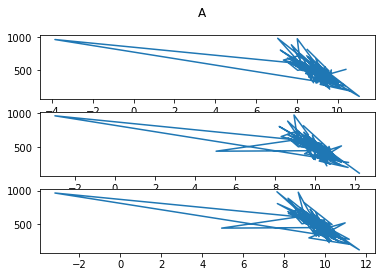

In [9]:
    print("connecting...")
    ftp = connect_ftp()
    print("accessing ftp...")
    df_ftp_dir = gen_df_ftp_dir()
    print("query...")
    df_station_desc_query = gen_df_station_desc_query()
    df_ftp_dir_query = gen_df_ftp_dir_query(df_ftp_dir,df_station_desc_query)
    print("downloading...")
    df_all = download_stations(df_station_desc_query)
    print("plotting...")
    plot(df_all)

In [10]:
df_ftp_dir

,fname,pname
station_id,,
1,jahreswerte_KL_00001_19310101_19851231_hist.zip,produkt_klima_jahr_19310101_19851231_00001.txt
3,jahreswerte_KL_00003_18510101_20101231_hist.zip,produkt_klima_jahr_18510101_20101231_00003.txt
44,jahreswerte_KL_00044_19720101_20191231_hist.zip,produkt_klima_jahr_19720101_20191231_00044.txt
52,jahreswerte_KL_00052_19730101_20011231_hist.zip,produkt_klima_jahr_19730101_20011231_00052.txt
61,jahreswerte_KL_00061_19760101_19771231_hist.zip,produkt_klima_jahr_19760101_19771231_00061.txt
...,...,...
15963,jahreswerte_KL_15963_19530101_20031231_hist.zip,produkt_klima_jahr_19530101_20031231_15963.txt
15965,jahreswerte_KL_15965_19700101_19831231_hist.zip,produkt_klima_jahr_19700101_19831231_15965.txt
15979,jahreswerte_KL_15979_19480101_19781231_hist.zip,produkt_klima_jahr_19480101_19781231_15979.txt


In [11]:
df_ftp_dir_query

,fname,pname
station_id,,
73,jahreswerte_KL_00073_19530101_20191231_hist.zip,produkt_klima_jahr_19530101_20191231_00073.txt
142,jahreswerte_KL_00142_19550101_20191231_hist.zip,produkt_klima_jahr_19550101_20191231_00142.txt
151,jahreswerte_KL_00151_18810101_20191231_hist.zip,produkt_klima_jahr_18810101_20191231_00151.txt
154,jahreswerte_KL_00154_19940101_20191231_hist.zip,produkt_klima_jahr_19940101_20191231_00154.txt
191,jahreswerte_KL_00191_18840101_20191231_hist.zip,produkt_klima_jahr_18840101_20191231_00191.txt
...,...,...
7412,jahreswerte_KL_07412_20070101_20191231_hist.zip,produkt_klima_jahr_20070101_20191231_07412.txt
7424,jahreswerte_KL_07424_20070101_20191231_hist.zip,produkt_klima_jahr_20070101_20191231_07424.txt
7431,jahreswerte_KL_07431_20080101_20191231_hist.zip,produkt_klima_jahr_20080101_20191231_07431.txt


In [12]:
df_station_desc_query

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
73,1953-01-01,2020-12-31,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
142,1955-01-01,2020-12-31,511,48.4060,11.3117,Altomünster-Maisbrunn,Bayern
151,1881-01-01,2020-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern
154,1994-01-01,2020-12-31,516,48.0197,12.2925,Amerang-Pfaffing,Bayern
191,1884-01-01,2020-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern
...,...,...,...,...,...,...,...
7412,2006-10-01,2020-12-31,340,50.0083,9.4238,Neuhütten/Spessart,Bayern
7424,2007-01-01,2020-12-31,457,47.7724,12.9073,Piding,Bayern
7431,2008-01-01,2020-12-31,604,48.0130,11.5524,Oberhaching-Laufzorn,Bayern


In [13]:
df_all

,altitude,latitude,longitude,name,yat_2017,yat_2018,yat_2019
station_id,,,,,,,
73,340,48.6159,13.0506,Aldersbach-Kriestorf,9.38,10.73,10.16
142,511,48.4060,11.3117,Altomünster-Maisbrunn,9.19,10.16,9.81
151,382,49.4691,11.8546,Amberg-Unterammersricht,9.30,10.39,10.09
154,516,48.0197,12.2925,Amerang-Pfaffing,8.91,9.98,9.57
191,217,49.9694,9.9114,Arnstein-Müdesheim,9.61,10.58,10.19
...,...,...,...,...,...,...,...
7412,340,50.0083,9.4238,Neuhütten/Spessart,8.98,10.04,9.64
7424,457,47.7724,12.9073,Piding,8.94,9.91,9.69
7431,604,48.0130,11.5524,Oberhaching-Laufzorn,8.72,9.60,9.06


df.replace(to_replace = -999,value = (np.nan),inplace=True)
df = df.dropna(subset = [(str(o1)),(str(o2))])